## Librerias necesarias
    ´´´python
    !pip install pandas
    !pip install seaborn
    ´´´

## Carga de datos: 
-Utiliza alguna biblioteca de análisis de datos en Python, como Pandas, para cargar los datos en un DataFrame. Asegúrate de que los datos estén en formato JSON o conviértelos a dicho formato si es necesario.

In [15]:
import os
from dotenv import load_dotenv
import pandas as pd
from sodapy import Socrata

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Obtener el token de la variable de entorno
app_token = os.getenv("APP_TOKEN")

# Verificar si el token está presente
if not app_token:
    raise ValueError("El token de la aplicación no está definido en el archivo .env")

# Inicializar el cliente Socrata con el app_token
cliente = Socrata('www.datos.gov.co', app_token, timeout=30)

# Definir el tamaño de la página
limit = 50000

# Inicializar el offset
offset = 0

# Contador para el nombre del archivo CSV
csv_count = 1

# Realizar solicitudes de forma repetida hasta que no haya más datos
while True:
    # Construir la consulta con la cláusula where para filtrar los datos desde el año 2020
    consulta = "departamento='CUNDINAMARCA' AND fechaobservacion >= '2023-01-01T00:00:00.000'"

    # Realizar la solicitud con la consulta construida
    result = cliente.get("sbwg-7ju4", where=consulta, limit=limit, offset=offset)

    # Verificar si hay resultados
    if len(result) == 0:
        break
    
    # Convertir los resultados en un DataFrame de Pandas
    df = pd.DataFrame.from_records(result)
    
    # Guardar los datos en un archivo CSV
    csv_filename = f"data_{csv_count}.csv"
    df.to_csv(csv_filename, index=False)
    
    # Incrementar el offset para la próxima solicitud
    offset += limit
    
    # Incrementar el contador de archivos CSV
    csv_count += 1





In [25]:
print(df.columns)


Index(['fechaobservacion', 'valorobservado', 'nombreestacion', 'departamento',
       'municipio', 'latitud', 'longitud', 'descripcionsensor'],
      dtype='object')


## Limpieza de datos: 
-Realiza tareas de limpieza de datos para asegurarte de que los datos estén en el formato correcto y no contengan valores nulos o incorrectos.

In [26]:
import os
import pandas as pd

# Directorio donde se encuentran los archivos CSV
directorio_csv = "/home/dev1/Documents/sergioarboleda/proyectoClima"

# Inicializar un DataFrame vacío para almacenar todos los datos
df_all = pd.DataFrame()

# Iterar sobre todos los archivos CSV en el directorio
for filename in os.listdir(directorio_csv):
    if filename.endswith(".csv"):
        # Leer el archivo CSV y cargar los datos en un DataFrame
        filepath = os.path.join(directorio_csv, filename)
        df = pd.read_csv(filepath)
        
        # Definir las columnas a mantener
        columnas_mantener = ['fechaobservacion', 'valorobservado', 'nombreestacion', 'departamento',
                             'municipio', 'latitud', 'longitud', 'descripcionsensor']
        
        # Eliminar las columnas que no están presentes en los datos
        columnas_a_eliminar = [col for col in df.columns if col not in columnas_mantener]
        df_clean = df.drop(columns=columnas_a_eliminar)
        
        # Convertir las columnas de fecha a tipo datetime
        df_clean['fechaobservacion'] = pd.to_datetime(df_clean['fechaobservacion'])
        
        # Convertir la columna 'valorobservado' a tipo numérico
        df_clean['valorobservado'] = pd.to_numeric(df_clean['valorobservado'], errors='coerce')
        
        # Eliminar filas con valores faltantes
        df_clean.dropna(inplace=True)
        
        # Agregar los datos limpios al DataFrame general
        df_all = pd.concat([df_all, df_clean], ignore_index=True)

# Guardar todos los datos limpios en un DataFrame en el mismo cuaderno
df_all.to_csv("datos_limpios_total.csv", index=False)

print("Limpieza de datos completada. Los datos limpios se han guardado en 'datos_limpios_total.csv'")



Limpieza de datos completada. Los datos limpios se han guardado en 'datos_limpios_total.csv'


# Análisis exploratorio de datos (EDA): 
-Explora tus datos para comprender mejor su distribución y características. Puedes visualizar la distribución de las temperaturas, identificar valores atípicos, y explorar la relación entre las variables.

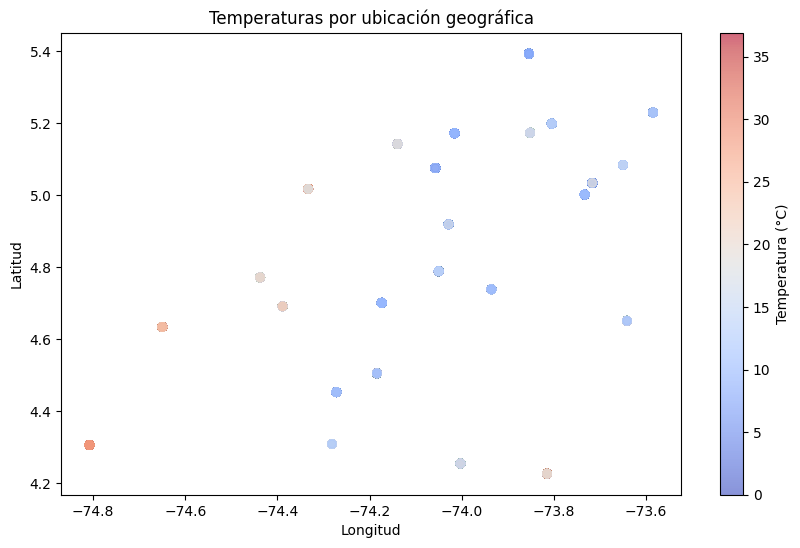

Valores atípicos:
       codigoestacion  codigosensor    fechaobservacion  valorobservado  \
385          21235030            68 2023-10-20 09:00:00    3.160000e+01   
1147         21235030            68 2023-10-11 11:00:00    3.450000e+01   
3097         21235030            68 2023-10-21 14:00:00    3.440000e+01   
5080         21235030            68 2023-10-20 11:00:00    3.280000e+01   
5173         21235030            68 2023-10-11 14:00:00    3.670000e+01   
5300         21235030            68 2023-10-11 12:00:00    3.590000e+01   
8231         21235030            68 2023-10-23 13:00:00    3.690000e+01   
9187         21235030            68 2023-10-23 23:00:00    3.030000e+01   
9754         21235030            68 2023-10-20 12:00:00    3.350000e+01   
9825         21235030            68 2023-10-23 16:00:00    3.540000e+01   
11049        21235030            68 2023-10-23 14:00:00    3.580000e+01   
13585        21235030            68 2023-10-21 16:00:00    3.390000e+01   
15164  

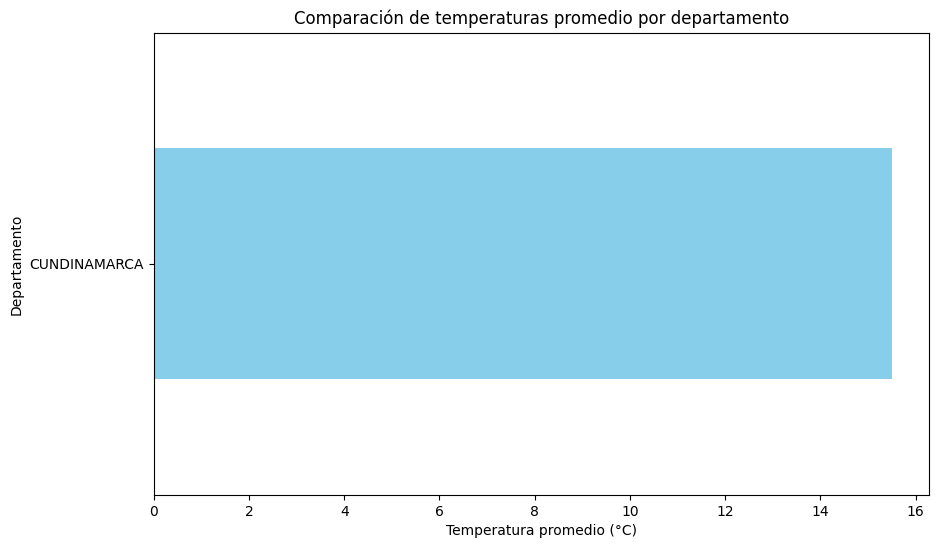

In [29]:
# Manejo de datos faltantes
df.dropna(inplace=True)

# Análisis de tendencias a lo largo del tiempo
df['year'] = df['fechaobservacion'].dt.year
df['month'] = df['fechaobservacion'].dt.month

# Análisis por ubicación geográfica
plt.figure(figsize=(10, 6))
plt.scatter(df['longitud'], df['latitud'], c=df['valorobservado'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Temperatura (°C)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Temperaturas por ubicación geográfica')
plt.show()

# Identificación de valores atípicos
Q1 = df['valorobservado'].quantile(0.25)
Q3 = df['valorobservado'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['valorobservado'] < Q1 - 1.5 * IQR) | (df['valorobservado'] > Q3 + 1.5 * IQR)]
print("Valores atípicos:")
print(outliers)

# Comparación entre departamentos
plt.figure(figsize=(10, 6))
df.groupby('departamento')['valorobservado'].mean().sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Temperatura promedio (°C)')
plt.ylabel('Departamento')
plt.title('Comparación de temperaturas promedio por departamento')
plt.show()



## Identificación de correlaciones: 
-Utiliza métodos estadísticos para identificar correlaciones entre las diferentes variables. Por ejemplo, puedes calcular la matriz de correlación y visualizarla utilizando un mapa de calor.

In [28]:
# Calcula la matriz de correlación
correlation_matrix = df.corr()

# Visualiza la matriz de correlación utilizando un mapa de calor
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


ValueError: could not convert string to float: 'GUAYABETAL POLLO OLIMPICO'